## 导入包

In [1]:
# Import what we need
import os
import sys
import numpy as np
import scipy.io
import scipy.misc
import tensorflow as tf  # Import TensorFlow after Scipy or Scipy will break
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from PIL import Image
%matplotlib inline

## 路径

In [2]:
# 输出图片的路径
OUTPUT_DIR = '/home/liuzixuan/实训/02-用Python快速实现图片的风格迁移/output'
# 风格图片的路径
STYLE_IMAGE = '/home/liuzixuan/实训/02-用Python快速实现图片的风格迁移/img/star.jpg'
# 内容图片的路径
CONTENT_IMAGE = '/home/liuzixuan/实训/02-用Python快速实现图片的风格迁移/img'
# VGG-19模型的路径
VGG_MODEL = '/home/liuzixuan/实训/02-用Python快速实现图片的风格迁移/刘子璇/imagenet-vgg-verydeep-19.mat'

## 所需常数定义

In [3]:
# 输出图片大小定义(224,224,3)
IMAGE_WIDTH = 224
IMAGE_HEIGHT = 224
COLOR_CHANNELS = 3
# 噪声比(与内容图像混合的噪声权重百分比)
NOISE_RATIO = 0.6
# Constant to put more emphasis on content loss.
BETA = 5
# Constant to put more emphasis on style loss.
ALPHA = 100
# 从VGG模型的输入中减去的平均值
MEAN_VALUES = np.array([123.68, 116.779, 103.939]).reshape((1,1,1,3))
# 训练次数
ITERATIONS = 1000 

## 定义模型函数

In [4]:
def load_vgg_model(path):
    """
    Returns a model for the purpose of 'painting' the picture.
    Takes only the convolution layer weights and wrap using the TensorFlow
    Conv2d, Relu and AveragePooling layer. VGG actually uses maxpool but
    the paper indicates that using AveragePooling yields better results.
    The last few fully connected layers are not used.
    Here is the detailed configuration of the VGG model:
        0 is conv1_1 (3, 3, 3, 64)
        1 is relu
        2 is conv1_2 (3, 3, 64, 64)
        3 is relu    
        4 is maxpool
        5 is conv2_1 (3, 3, 64, 128)
        6 is relu
        7 is conv2_2 (3, 3, 128, 128)
        8 is relu
        9 is maxpool
        10 is conv3_1 (3, 3, 128, 256)
        11 is relu
        12 is conv3_2 (3, 3, 256, 256)
        13 is relu
        14 is conv3_3 (3, 3, 256, 256)
        15 is relu
        16 is conv3_4 (3, 3, 256, 256)
        17 is relu
        18 is maxpool
        19 is conv4_1 (3, 3, 256, 512)
        20 is relu
        21 is conv4_2 (3, 3, 512, 512)
        22 is relu
        23 is conv4_3 (3, 3, 512, 512)
        24 is relu
        25 is conv4_4 (3, 3, 512, 512)
        26 is relu
        27 is maxpool
        28 is conv5_1 (3, 3, 512, 512)
        29 is relu
        30 is conv5_2 (3, 3, 512, 512)
        31 is relu
        32 is conv5_3 (3, 3, 512, 512)
        33 is relu
        34 is conv5_4 (3, 3, 512, 512)
        35 is relu
        36 is maxpool
        37 is fullyconnected (7, 7, 512, 4096)
        38 is relu
        39 is fullyconnected (1, 1, 4096, 4096)
        40 is relu
        41 is fullyconnected (1, 1, 4096, 1000)
        42 is softmax
    """
    vgg = scipy.io.loadmat(path)

    vgg_layers = vgg['layers']
    # 定义权重函数(返回各层权重及偏置值)
    def _weights(layer, expected_layer_name):
        W = vgg_layers[0][layer][0][0][0][0][0]
        b = vgg_layers[0][layer][0][0][0][0][1]
        layer_name = vgg_layers[0][layer][0][0][-2]
        assert layer_name == expected_layer_name
        return W, b
    # 定义各层函数
    def _relu(conv2d_layer):
        return tf.nn.relu(conv2d_layer)

    def _conv2d(prev_layer, layer, layer_name):
        W, b = _weights(layer, layer_name)
        W = tf.constant(W)
        b = tf.constant(np.reshape(b, (b.size)))
        return tf.nn.conv2d(
            prev_layer, filter=W, strides=[1, 1, 1, 1], padding='SAME') + b

    def _conv2d_relu(prev_layer, layer, layer_name):
        return _relu(_conv2d(prev_layer, layer, layer_name))

    def _avgpool(prev_layer):
        return tf.nn.avg_pool(prev_layer, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

    # 构造图形模型
    graph = {}
    graph['input']   = tf.Variable(np.zeros((1, IMAGE_HEIGHT, IMAGE_WIDTH, COLOR_CHANNELS)), dtype = 'float32')
    graph['conv1_1']  = _conv2d_relu(graph['input'], 0, 'conv1_1')
    graph['conv1_2']  = _conv2d_relu(graph['conv1_1'], 2, 'conv1_2')
    graph['avgpool1'] = _avgpool(graph['conv1_2'])
    graph['conv2_1']  = _conv2d_relu(graph['avgpool1'], 5, 'conv2_1')
    graph['conv2_2']  = _conv2d_relu(graph['conv2_1'], 7, 'conv2_2')
    graph['avgpool2'] = _avgpool(graph['conv2_2'])
    graph['conv3_1']  = _conv2d_relu(graph['avgpool2'], 10, 'conv3_1')
    graph['conv3_2']  = _conv2d_relu(graph['conv3_1'], 12, 'conv3_2')
    graph['conv3_3']  = _conv2d_relu(graph['conv3_2'], 14, 'conv3_3')
    graph['conv3_4']  = _conv2d_relu(graph['conv3_3'], 16, 'conv3_4')
    graph['avgpool3'] = _avgpool(graph['conv3_4'])
    graph['conv4_1']  = _conv2d_relu(graph['avgpool3'], 19, 'conv4_1')
    graph['conv4_2']  = _conv2d_relu(graph['conv4_1'], 21, 'conv4_2')
    graph['conv4_3']  = _conv2d_relu(graph['conv4_2'], 23, 'conv4_3')
    graph['conv4_4']  = _conv2d_relu(graph['conv4_3'], 25, 'conv4_4')
    graph['avgpool4'] = _avgpool(graph['conv4_4'])
    graph['conv5_1']  = _conv2d_relu(graph['avgpool4'], 28, 'conv5_1')
    graph['conv5_2']  = _conv2d_relu(graph['conv5_1'], 30, 'conv5_2')
    graph['conv5_3']  = _conv2d_relu(graph['conv5_2'], 32, 'conv5_3')
    graph['conv5_4']  = _conv2d_relu(graph['conv5_3'], 34, 'conv5_4')
    graph['avgpool5'] = _avgpool(graph['conv5_4'])
    return graph

## 内容损失函数

In [5]:
def content_loss_func(sess, model):
    def _content_loss(p, x):
        # 过滤器数量(即为通道数)
        N = p.shape[3]
        # ｆｅａｔｕｒｅ_map大小
        M = p.shape[1] * p.shape[2]
        return (1 / (4 * N * M)) * tf.reduce_sum(tf.pow(x - p, 2))
    return _content_loss(sess.run(model['conv4_2']), model['conv4_2'])

## 风格损失函数

In [6]:
# 若to have softer features可适当增加较高层(conv5_1)的权重,并降低下层(conv1_1)的权重
# 若ｔｏ have harder features可降低较高层(conv5_1)的权重，并增加下层(conv1_1)的权重
STYLE_LAYERS = [
    ('conv1_1', 0.5),
    ('conv2_1', 1.0),
    ('conv3_1', 1.5),
    ('conv4_1', 3.0),
    ('conv5_1', 4.0),
]

def style_loss_func(sess, model):
    # 定义ｇｒａｍ函数
    def _gram_matrix(F, N, M):
        Ft = tf.reshape(F, (M, N))
        return tf.matmul(tf.transpose(Ft), Ft)

    def _style_loss(a, x):
        # 过滤器数量
        N = a.shape[3]
        # ｆｅａｔｕｒｅ_map大小
        M = a.shape[1] * a.shape[2]
        # 原始图像的样式表示
        A = _gram_matrix(a, N, M)
        # 生成图像的样式表示
        G = _gram_matrix(x, N, M)
        result = (1 / (4 * N**2 * M**2)) * tf.reduce_sum(tf.pow(G - A, 2))
        return result

    E = [_style_loss(sess.run(model[layer_name]), model[layer_name]) for layer_name, _ in STYLE_LAYERS]
    W = [w for _, w in STYLE_LAYERS]
    loss = sum([W[l] * E[l] for l in range(len(STYLE_LAYERS))])
    return loss

## 噪声图像

In [7]:
def generate_noise_image(content_image, noise_ratio = NOISE_RATIO):
    # 噪声图像:与内容图像以一定比例混合
    noise_image = np.random.uniform(
            -20, 20,
            (1, IMAGE_HEIGHT, IMAGE_WIDTH, COLOR_CHANNELS)).astype('float32')
    # 加权平均值
    input_image = noise_image * noise_ratio + content_image * (1 - noise_ratio)
    return input_image

## 读取图片

In [8]:
def load_image(path):
    image = scipy.misc.imread(path)
    # 统一图片大小(1,224,224,3)
    image = scipy.misc.imresize(image,(224,224,3))
    image = np.reshape(image, ((1,) + image.shape))
    # VGG模型的输入需要减去平均值
    image = image - MEAN_VALUES
    return image

## 图片存储

In [9]:
def save_image(path, image):
    # 输出图片需要加回平均值
    image = image + MEAN_VALUES
    # 去掉第一个无用的维度，剩下的就是图像
    image = image[0]
    image = np.clip(image, 0, 255).astype('uint8')
    scipy.misc.imsave(path, image)

In [12]:
#再写一个ｐｌａｃｅholder，用ｓｅｓｓ填补
with tf.Graph().as_default() as g:
    content = tf.placeholder(shape=[None,224,224,3],dtype=tf.float32)
    style = tf.placeholder(shape=[None,224,224,3],dtype=tf.float32)
    # 模型加载
    model = load_vgg_model(VGG_MODEL)
    
    # 内容损失
    sess.run(model['input'].assign(content))
    content_loss = content_loss_func(sess, model)
    
    # 风格损失
    sess.run(model['input'].assign(style))
    style_loss = style_loss_func(sess, model)
    #总损失
    total_loss = BETA * content_loss + ALPHA * style_loss
    #with tf.Session() as sess1:
        # 内容损失
    #    sess1.run(model['input'].assign(content))
    #    content_loss = content_loss_func(sess1, model)
    
        # 风格损失
    #    sess1.run(model['input'].assign(style))
    #    style_loss = style_loss_func(sess1, model)
        #总损失
    #total_loss = BETA * content_loss + ALPHA * style_loss

TypeError: Expected DataType for argument 'dtype' not <class 'tensorflow.python.client.session.Session'>.

In [23]:
tf.Graph??

In [17]:
content_images = []
for i in range(1,6):
    content_image = load_image(CONTENT_IMAGE+'/'+'img0'+str(i)+'.jpg')
    content_images.append(content_image)

/home/liuzixuan/test/lib/python3.5/site-packages/ipykernel_launcher.py:2: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  
/home/liuzixuan/test/lib/python3.5/site-packages/ipykernel_launcher.py:4: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  after removing the cwd from sys.path.


(1, 224, 224, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


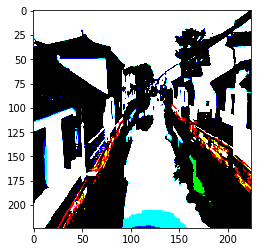

In [18]:
print(content_images[0].shape)
imshow(content_images[0][0])
#print(type(content_images[0]))
#print(content_images[0])

## 训练

In [22]:
with tf.Session(graph=g) as sess:
    #优化器
    optimizer = tf.train.AdamOptimizer(2.0)
    train_step = optimizer.minimize(total_loss)
    sess.run(tf.global_variables_initializer())
    
    # 风格图片
    style_image = load_image(STYLE_IMAGE)
    #imshow(style_image[0])
    
    # 训练模型
    batch_size = 1
    group_train = len(content_images)//batch_size
    for step in range(1000):
        #batch_images, batch_labels = mnist.train.next_batch(32)
        loss = []
        for train_step in range(group_train):
            batch_images = content_images[train_step*batch_size:train_step*batch_size+batch_size,:]
            res_loss,_ = sess.run([loss,train_step],feed_dict={content:batch_images,style:style_image})
            loss.append(res_loss)
        avg_loss = np.mean(loss)
        print('step %5d, loss %2.4f' % (step, avg_loss))
    
    
    
    # 风格图片
    #style_image = load_image(STYLE_IMAGE)
    #imshow(style_image[0])

    # 模型加载
    #model = load_vgg_model(VGG_MODEL)
    #print(model)

    #print(content_image.shape)
    #print(style_image.shape)
    #for i  in range(1,6):
        # 内容图片
    #    content_image = load_image(CONTENT_IMAGE+'/'+'img0'+str(i)+'.jpg')
    #    #imshow(content_image[0])
    
        # 输入图片
    #    input_image = generate_noise_image(content_image)
        #imshow(input_image[0])
    
        # 内容损失
    #    sess.run(model['input'].assign(content_image))
    #    content_loss = content_loss_func(sess, model)
    
        # 风格损失
    #    sess.run(model['input'].assign(style_image))
    #    style_loss = style_loss_func(sess, model)
    
        #总损失
    #    total_loss = BETA * content_loss + ALPHA * style_loss
    
        #优化器
    #    optimizer = tf.train.AdamOptimizer(2.0)
    #    train_step = optimizer.minimize(total_loss)
        
    #    sess.run(tf.initialize_all_variables())
    #    sess.run(model['input'].assign(input_image))
    #    sess.run(tf.initialize_all_variables())
    #    sess.run(model['input'].assign(input_image))
        print('img0',i)
        for j in range(ITERATIONS):
            sess.run(train_step)
            # 每迭代１００次输出一次
            if j%100 == 0:
                mixed_image = sess.run(model['input'])
                print('Iteration %d' % (j))
                print('sum : ', sess.run(tf.reduce_sum(mixed_image)))
                print('cost: ', sess.run(total_loss))

                if not os.path.exists(OUTPUT_DIR):
                    os.mkdir(OUTPUT_DIR)

                filename = OUTPUT_DIR + '/' + 'img0'+ str(i)+'_'+ str(j) + '.jpg' 
                save_image(filename, mixed_image)
        print('###########################################################################')
        saver.save(sess,'model'+str(i))

/home/liuzixuan/test/lib/python3.5/site-packages/ipykernel_launcher.py:2: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  
/home/liuzixuan/test/lib/python3.5/site-packages/ipykernel_launcher.py:4: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  after removing the cwd from sys.path.


img0 1
Iteration 0
sum :  288513.8
cost:  142955510000.0


/home/liuzixuan/test/lib/python3.5/site-packages/ipykernel_launcher.py:7: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
  import sys


Iteration 100
sum :  -33583.406
cost:  1937699100.0
Iteration 200
sum :  -222127.12
cost:  1050811300.0
Iteration 300
sum :  -380975.78
cost:  733068540.0
Iteration 400
sum :  -535154.75
cost:  560131200.0
Iteration 500
sum :  -687636.2
cost:  447830750.0
Iteration 600
sum :  -836054.75
cost:  371268930.0
Iteration 700
sum :  -980406.3
cost:  317821200.0
Iteration 800
sum :  -1119500.9
cost:  278407550.0
Iteration 900
sum :  -1254101.5
cost:  247162350.0
###########################################################################
img0 2
Iteration 0
sum :  -2314898.5
cost:  138037130000.0
Iteration 100
sum :  -2446308.0
cost:  2645558300.0
Iteration 200
sum :  -2563396.0
cost:  1246245000.0
Iteration 300
sum :  -2653029.8
cost:  802734100.0
Iteration 400
sum :  -2733878.5
cost:  578023500.0
Iteration 500
sum :  -2807591.5
cost:  442662430.0
Iteration 600
sum :  -2873041.2
cost:  354036640.0
Iteration 700
sum :  -2932815.5
cost:  294721440.0
Iteration 800
sum :  -2986962.0
cost:  25404260